In [1]:
# SWAN: install packages into "python_env" folder and add to PYTHONPATH
import os
import sys
if "SWAN_HOME" in os.environ:
    if not os.path.exists("python_env"):
        !pip install --target python_env "uproot==5.1.2" "awkward==2.5.0" "vector==1.1.1"
    python_path = "./python_env"
    if not python_path in sys.path:
        sys.path.insert(0, python_path)

# Tutorial: analyze PHYSLITE with uproot, awkward and vector

In [2]:
import copy
import os

import uproot
import awkward as ak
import vector
vector.register_awkward()
import matplotlib.pyplot as plt
import tqdm

In [3]:
# mc23_13p6TeV.601229.PhPy8EG_A14_ttbar_hdamp258p75_SingleLep.deriv.DAOD_PHYSLITE.e8514_s4159_r14799_p5855
filename = "DAOD_PHYSLITE.35040162._000001.pool.root.1"

In [4]:
from urllib.request import urlretrieve
url = "https://cernbox.cern.ch/remote.php/dav/public-files/HvbDTmNq40fg227/DAOD_PHYSLITE.35040162._000001.pool.root.1"
if not os.path.exists(filename):
    urlretrieve(url, filename)

# Read PHYSLITE with uproot

We can open a `TFile` using `uproot.open`. To directly get the `TTree`, pass a dictionary with `{filename: treename}`

In [5]:
tree = uproot.open({filename: "CollectionTree"})

## List branches
Most of the data in PHYSLITE is in "AuxDyn" branches and represents `vector<something>` in c++ where something is any fundamental type (float, int)

In [6]:
tree.show(name_width=50, typename_width=50)

name                                               | typename                                           | interpretation                
---------------------------------------------------+----------------------------------------------------+-------------------------------
xTrigDecisionAux.                                  | xAOD::TrigDecisionAuxInfo_v1                       | AsGroup(<TBranchElement 'xT...
xTrigDecisionAux./xTrigDecisionAux.xAOD::AuxInf... | unknown                                            | <UnknownInterpretation 'non...
xTrigDecisionAux./xTrigDecisionAux.smk             | uint32_t                                           | AsDtype('>u4')
xTrigDecisionAux./xTrigDecisionAux.bgCode          | int8_t                                             | AsDtype('int8')
xTrigDecisionAux./xTrigDecisionAux.tav             | std::vector<uint32_t>                              | AsJagged(AsDtype('>u4'), he...
xTrigDecisionAux./xTrigDecisionAux.tap             | std::vector<uint32_

## Load into awkward and numpy arrays

We can get branches of a TTree by using `[...]` and calling `.array()`

In [7]:
el_pt = tree["AnalysisElectronsAuxDyn.pt"].array()

These vector branches are represented using awkward array:

In [8]:
el_pt

<Array [[], [6.9e+04], [...], ..., [], []] type='20000 * var * float32'>

For plotting it can make sense to flatten them and convert to numpy:

In [9]:
el_pt_np = ak.flatten(el_pt).to_numpy()
el_pt_np

array([68997.33 , 68479.836, 14511.322, ...,  3006.725, 17596.412,
       20609.775], dtype=float32)

In [10]:
len(el_pt_np)

10676

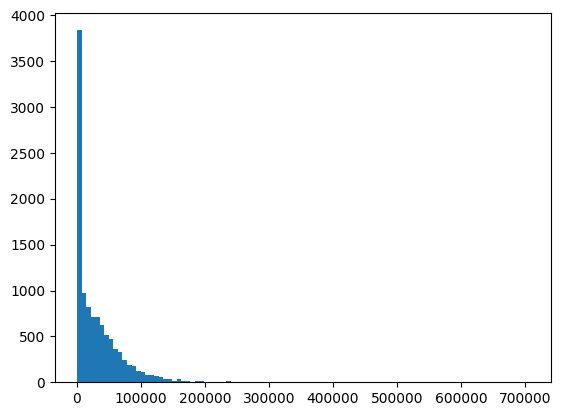

In [11]:
plt.hist(el_pt_np, bins=100);

# Simple ttbar analysis

To demonstrate a bit how this works we can run a very basic ttbar analysis.

Inspired by the [Analysis Grand Challenge (AGC)](https://agc.readthedocs.io/en/latest/) we attempt to reconstruct a hadronically decaying top quark for semi-leptonic ttbar events. Copying their graphic here:

![](img/ttbar.png)

## Collect branches into records

For this we need some more information from our PHYSLITE file

In [12]:
electrons = ak.zip(
    {
        "pt": tree["AnalysisElectronsAuxDyn.pt"].array(),
        "eta": tree["AnalysisElectronsAuxDyn.eta"].array(),
        "phi": tree["AnalysisElectronsAuxDyn.phi"].array(),
    }
)

muons = ak.zip(
     {
        "pt": tree["AnalysisMuonsAuxDyn.pt"].array(),
        "eta": tree["AnalysisMuonsAuxDyn.eta"].array(),
        "phi": tree["AnalysisMuonsAuxDyn.phi"].array(),
    }
)

jets = ak.zip(
     {
        "pt": tree["AnalysisJetsAuxDyn.pt"].array(),
        "eta": tree["AnalysisJetsAuxDyn.eta"].array(),
        "phi": tree["AnalysisJetsAuxDyn.phi"].array(),
        "mass": tree["AnalysisJetsAuxDyn.m"].array(),
    }
)

These are now record arrays

In [13]:
electrons

<Array [[], [{pt: 6.9e+04, ...}], ..., [], []] type='20000 * var * {pt: flo...'>

where we can access the fields conveniently via attribute or dictionary access:

In [14]:
electrons.pt

<Array [[], [6.9e+04], [...], ..., [], []] type='20000 * var * float32'>

In [15]:
electrons["pt"]

<Array [[], [6.9e+04], [...], ..., [], []] type='20000 * var * float32'>

For the jets we'll also need BTagging information. Technically this would be provided by ElementLinks (cross references), but here in PHYSLITE we have exactly one btagging value for each jet:

In [16]:
btag_prob = tree["BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb"].array()

In [17]:
ak.all(ak.num(btag_prob) == ak.num(jets))

True

So we can just attach this as an additional field to our jets:

In [18]:
jets["btag_prob"] = btag_prob

In [19]:
jets

<Array [[{pt: 2.24e+05, ...}, ..., {...}], ...] type='20000 * var * {pt: fl...'>

To also do event selections conveniently we zip all objects together to a single `events` record array. We need to pass `depth_limit=1` since the lists can have arbitrary lengths at the second (index 1) dimension. The first dimension (events) has to have the same length for this to make sense

In [20]:
events = ak.zip({"Electrons": electrons, "Muons": muons, "Jets": jets}, depth_limit=1)
events

<Array [{Electrons: [], Muons: ..., ...}, ...] type='20000 * {Electrons: va...'>

## Event and object selection
Now, we are ready to do an event and object selection:

- at least 4 Jets (1 from the leptonic decay, 3 from the hadronic one)
- exactly one (reasonably high transverse momentum and central) Electron or Muon
- choose btagging with 85% working point
- at least 2 bjets

### Basic object selections

Selections work like in `numpy`, by passing a boolean mask in `[...]`, just here it also generalizes to lists (vector branches)

In [21]:
GeV = 1000.

In [22]:
mask = electrons.pt > 30 * GeV
mask

<Array [[], [True], [True, False], ..., [], []] type='20000 * var * bool'>

In [23]:
electrons[mask]

<Array [[], [{pt: 6.9e+04, ...}], ..., [], []] type='20000 * var * {pt: flo...'>

In [24]:
def selected_electrons(el):
    return el[(el.pt > 30 * GeV) & (abs(el.eta) < 2.47)]

def selected_muons(mu):
    return mu[(mu.pt > 30 * GeV) & (abs(mu.eta) < 2.47)]

def selected_jets(j):
    return j[(j.pt > 30 * GeV) & (abs(j.eta) < 2.47)]

We apply these selections to all our objects in the `events` record:

In [25]:
events["Electrons"] = selected_electrons(electrons)
events["Muons"] = selected_muons(muons)
events["Jets"] = selected_jets(jets)

In [26]:
ak.count(electrons.pt) # before selecton

10676

In [27]:
ak.count(events.Electrons.pt) # after selection

4255

### (Lorentz) vectors

Now, we also may want to do Lorentz vector calculation. For this we use the `vector` package to make our objects behave like vectors

In [28]:
events["Electrons"] = vector.awk(events.Electrons)
events["Muons"] = vector.awk(events.Muons)
events["Jets"] = vector.awk(events.Jets)

In [29]:
events.Electrons

<MomentumArray3D [[], [{rho: 6.9e+04, ...}], ..., [], []] type='20000 * var...'>

In [30]:
events.Electrons.px

<Array [[], [2.25e+04], [6.72e+04], ..., [], []] type='20000 * var * float32'>

### Overlap removal

We won't do anything sophisticated, but it may be worth looking at the overlap between electrons and jets

This is something that involves **all combinations** of an electron and a jet, the **cartesian product** between these lists:

In [31]:
jj, ee = ak.unzip(ak.cartesian([events.Jets, events.Electrons], nested=True))

- `nested=True` means we add another dimension (the list of combinations)
- `ak.unzip` will make a **tuple of arrays** out of the **array of tuples** that was returned by `ak.cartesian`

In [32]:
jj.ndim

3

These are still vectors, so we can apply the `deltaR` method:

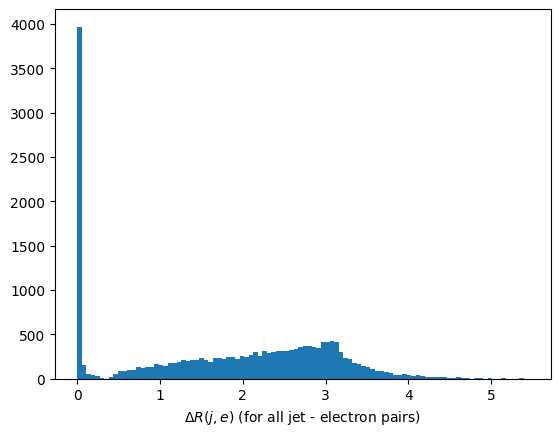

In [33]:
plt.hist(ak.flatten(jj.deltaR(ee), axis=None).to_numpy(), bins=100)
plt.xlabel("$\Delta R(j, e)$ (for all jet - electron pairs)");

We may want to remove these jets that overlap within `deltaR=0.4` with the electrons

In [34]:
def no_overlap(obj1, obj2, deltaR=0.4):
    obj1, obj2 = ak.unzip(ak.cartesian([obj1, obj2], nested=True))
    return ak.all(obj1.deltaR(obj2) > deltaR, axis=-1)

In [35]:
no_overlap(events.Jets, events.Electrons) # mask for each jet if it has no overlap with any electron

<Array [[True, True], ..., [True, True, ..., True]] type='20000 * var * bool'>

In [36]:
events["Jets"] = events.Jets[no_overlap(events.Jets, events.Electrons)]

### Apply event selection

In [37]:
events["Jets", "is_bjet"] = events.Jets.btag_prob > 0.85  # please tell me if this is wrong ;)

In [38]:
events = events[
    (ak.num(events.Jets) >= 4) # at least 4 jets
    & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 1) # exactly one lepton
    & (ak.num(events.Jets[events.Jets.is_bjet]) >= 2) # at least two btagged jets with prob > 0.85
]

In [39]:
len(events)

1045

## Top quark reconstruction

Now we do a simple top quark reconstruction:

- Form all combinations of 3 jets
- Require at least one bjet in the combination
- Choose the candidate with largest transverse momentum

In [40]:
def mjjj(jets):
    candidates = ak.combinations(jets, 3)
    j1, j2, j3 = ak.unzip(candidates)
    has_b = (j1.is_bjet + j2.is_bjet + j3.is_bjet) > 0
    candidates["p4"] = j1 + j2 + j3
    candidates = candidates[has_b]
    candidates = candidates[ak.argmax(candidates.p4.pt, axis=1, keepdims=True)]
    return candidates.p4.mass

In [41]:
mjjj(events.Jets)

<Array [[2.18e+05], [1.58e+05], ..., [2.18e+05]] type='1045 * var * ?float32'>

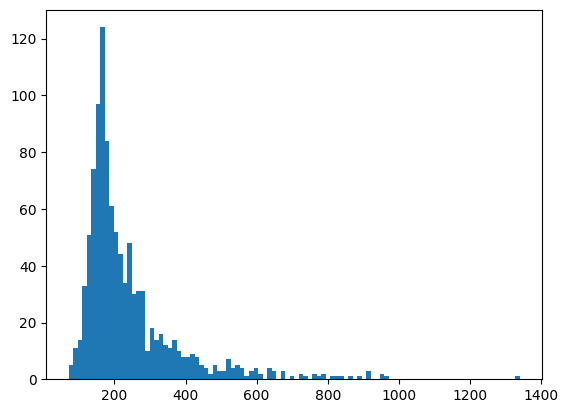

In [42]:
plt.hist(ak.flatten(mjjj(events.Jets) / GeV, axis=None), bins=100);

# Run on larger number of files

If we want to run this on a larger set of files we may run into memory issues after some point. There are two ways out:

- chunk the processing into steps where memory can be released afterwards, e.g. fill histogram or ntuple after each chunk
- go distributed

We won't discuss distributed processing in this tutorial, but there are nice possibilities to do this while still staying interactive by using [`dask`](https://www.dask.org/)

Here we will now process our data in chunks (one file at a time). In fact, we don't even need to go straight to a histogram. Since our event selection throws away lots of events and we don't keep many columns we can load a rather large sample of these into memory. Using `ak.to_packed` we can "project" out all the masks and indices to only use the memory needed:

In [43]:
ak.to_packed(events).nbytes / 1024 # memory usage in kiB

138.5625

### Organize code into functions
irst, we structure everything a bit more nicely into functions

In [44]:
schema = {
    "Electrons": [
        "pt", "eta", "phi",
    ],
    "Muons": [
        "pt", "eta", "phi",
    ],
    "Jets": [
        "pt", "eta", "phi", "m"
    ],
    "BTagging_AntiKt4EMPFlow": [
        "DL1dv01_pb",
    ]
}

In [45]:
def read_events(filename, schema):
    with uproot.open({filename: "CollectionTree"}) as tree:
        events = {}
        for objname, fields in schema.items():
            base = objname
            if objname in ["Electrons", "Muons", "Jets"]:
                base = "Analysis" + objname
                ak_zip = vector.zip
            else:
                ak_zip = ak.zip
            arrays = tree.arrays(
                fields,
                aliases={field: f"{base}AuxDyn.{field}" for field in fields},
            )
            arrays = ak_zip(dict(zip(arrays.fields, ak.unzip(arrays))))
            events[objname] = arrays
        return ak.zip(events, depth_limit=1)

In [46]:
events = read_events(filename, schema)
events

<Array [{Electrons: [], Muons: ..., ...}, ...] type='20000 * {Electrons: va...'>

In [47]:
def processed(events):
    events = copy.copy(events) # shallow copy
    events["Jets", "btag_prob"] = events.BTagging_AntiKt4EMPFlow.DL1dv01_pb
    events["Electrons"] = selected_electrons(events.Electrons)
    events["Muons"] = selected_muons(events.Muons)
    events["Jets"] = selected_jets(events.Jets)
    events["Jets"] = events.Jets[no_overlap(events.Jets, events.Electrons)]
    events["Jets", "is_bjet"] = events.Jets.btag_prob > 0.85
    events = events[
        (ak.num(events.Jets) >= 4) # at least 4 jets
        & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 1) # exactly one lepton
        & (ak.num(events.Jets[events.Jets.is_bjet]) >= 2) # at least two btagged jets with prob > 0.85
    ]
    return ak.to_packed(events)

In [48]:
processed(events)

<Array [{...}, {...}, {...}, ..., {...}, {...}] type='1045 * {BTagging_Anti...'>

## Pause a second and talk about performance

This is a good place to quickly review performance and what time is spent for what
- time for reading arrays into memory

In [49]:
%timeit read_events(filename, schema)

1.53 s ± 303 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- for this small file and this small amount of branches we spend most of the time just reading metadata (get the TTree object and branches - looking forward to RNtuple where this will probably be better)

In [50]:
def only_open():
    with uproot.open({filename: "CollectionTree"}) as tree:
        return tree

In [51]:
%timeit only_open()

1.11 s ± 149 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- processing time is much faster in this case

In [52]:
%timeit processed(events)

93.6 ms ± 28.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Small demonstration: process 1 million events from eos (single core)

**Note**: The following should run **out of box on SWAN**. If you run it **locally** you **need** to have a **VOMS proxy** certificate setup and the environment variables `X509_USER_PROXY` and `X509_CERT_DIR` appropriately set (`voms-proxy-init`)

In [53]:
urls = [
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/8f/11/DAOD_PHYSLITE.35010062._000001.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/83/7f/DAOD_PHYSLITE.35010062._000002.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/b4/72/DAOD_PHYSLITE.35010062._000003.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/d9/6b/DAOD_PHYSLITE.35010062._000004.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/d0/17/DAOD_PHYSLITE.35010062._000005.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/39/a6/DAOD_PHYSLITE.35010062._000006.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/e8/9a/DAOD_PHYSLITE.35010062._000007.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/c8/0d/DAOD_PHYSLITE.35010062._000008.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/a2/49/DAOD_PHYSLITE.35010062._000009.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/f6/9b/DAOD_PHYSLITE.35010062._000010.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/35/16/DAOD_PHYSLITE.35010062._000011.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/8a/37/DAOD_PHYSLITE.35010062._000012.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/3c/66/DAOD_PHYSLITE.35010062._000013.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/df/b9/DAOD_PHYSLITE.35010062._000014.pool.root.1",
    "root://eosatlas.cern.ch:1094//eos/atlas/atlasdatadisk/rucio/mc23_13p6TeV/7c/43/DAOD_PHYSLITE.35010062._000015.pool.root.1",
]

In [54]:
total = sum(entries for _, _, entries in uproot.num_entries({_url: "CollectionTree" for _url in urls}))
total

1010000

In [55]:
arrays = []
with tqdm.tqdm(total=total) as pbar:
    for url in urls:
        array = read_events(url, schema)
        pbar.update(len(array))
        array = processed(array)
        arrays.append(array)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010000/1010000 [03:03<00:00, 5500.58it/s]


In [56]:
events = ak.concatenate(arrays)

In [57]:
len(events)

54239

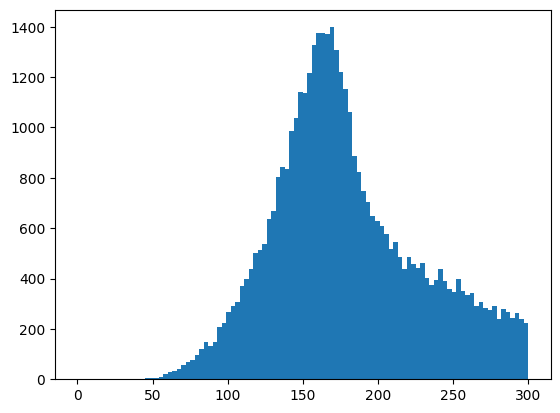

In [58]:
plt.hist(mjjj(events.Jets) / GeV, bins=100, range=(0, 300));

# Further information

## Other Studies and presentations by me

- My first study with PHYSLITE and columnar analysis in python for VCHEP21: https://doi.org/10.1051/epjconf/202125103001
- Tutorial: How to work with Elementlinks: https://gitlab.cern.ch/nihartma/awkward-elementlinks
- [(Older) introduction to PHYSLITE schema `coffea.nanoevents`](https://github.com/nikoladze/agc-tools-workshop-2021-physlite) (making all this structuring automatic, lazy loaded)  
  → [recent update on this (dask_awkward etc...)](https://indico.cern.ch/event/1328378/contributions/5590897/attachments/2726187/4738747/nikolai_amg_sc_physlite-coffea-03.10.2023_v2.pdf)
- [Collection of notebooks for large scale tests within the ATLAS google cloud project](https://github.com/gcp4hep/analysis-code/tree/main/notebooks)

## Current issues and TODOs

- Broken reading of some ElementLink branches [scikit-hep/uproot5#951](https://github.com/scikit-hep/uproot5/issues/951)  
  → should we make our own package for reading more complicated xAOD branches (anything nested higher than vector<int/float>)?  
  → could do this using custom interpretations passed through via the `filter_branch` argument to `uproot.open`
- TODOs for PHYSLITE schema in coffea [CoffeaTeam/coffea#540](https://github.com/CoffeaTeam/coffea/issues/540)
- Reading of PHYSLITE RNtuple needs update of spec and a fix for colons in object name [scikit-hep/uproot5#928](https://github.com/scikit-hep/uproot5/issues/928), [scikit-hep/uproot5#975](https://github.com/scikit-hep/uproot5/issues/975)

## How are we going to do systematics with this?

![](img/grusplan_systematics.png)

There is quite some effort ongoing to get corrections/systematics working within this setup, referring to developments by Matthias Vigl here:
- https://indico.cern.ch/event/1328378/contributions/5590867/attachments/2717839/4738591/Columnar_CPtools.pdf
- https://indico.cern.ch/event/1345199/contributions/5662967/attachments/2763293/4812626/Columnar_CS.pdf